In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

import scipy
from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

In [2]:
def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)

    # There should be a method for this, but there isn't... Pull request?
    ax2._r_label_position._t = (22.5 + 180, 0.0)
    ax2._r_label_position.invalidate()
    return ax2

def plot_scale(r_max_psi, r_max_P):
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    fig, axs = plt.subplots(1,1,subplot_kw=dict(polar=True))

    axs.vlines(-np.pi/2, 0, r_max_psi, color='lightcoral', alpha=0.8, zorder=3, linewidth=4)

    axs.set_rmax(r_max_psi)
    #axs.set_rticks([0,r_max_psi/2,r_max_psi], [r'0', str(round(r_max_psi/2,3)),str(round(r_max_psi,3))], color='lightcoral', fontsize=38)
    #axs.set_rlabel_position(275)
    axs.set_rticks([0,r_max_psi/2,r_max_psi], [r'', r'',r''], color='lightcoral', fontsize=38)
    
    axs.annotate(str(0), xy=(-np.pi/2, r_max_psi), xytext=(-0.94*np.pi/2, 0.24*r_max_psi), fontsize=38, color='lightcoral')
    axs.annotate(str(round(r_max_psi/2,3)), xy=(-np.pi/2, r_max_psi), xytext=(-0.98*np.pi/2, 1.45*r_max_psi/2), fontsize=38, color='lightcoral')
    axs.annotate(str(round(r_max_psi,3)), xy=(-np.pi/2, r_max_psi), xytext=(-0.98*np.pi/2, 1.24*r_max_psi), fontsize=38, color='lightcoral')

    #axs.set_xticklabels([0,np.pi/2,np.pi,3*np.pi/2],[0,np.pi/2,np.pi,3*np.pi/2])
    axs.set_xticks([0,np.pi/2,np.pi,3*np.pi/2])
    #axs.set_thetagrids([0,45,90,180,225,270],[r'$0$',r'',r'$\pi/2$',r'$\pi$',r'',r'$3\pi/2$'], fontsize=38, color='blue')
    axs.set_thetagrids([0,90,180,270],[r'$0$',r'',r'$\pi$',r''], fontsize=38, color='blue')

    axs.annotate(r'$|\varphi_{ij}|^2$', xy=(-np.pi/2, r_max_psi), xytext=(-1.12*np.pi/2, 1.7*r_max_psi), fontsize=45, color='lightcoral')


    axs_twin = polar_twin(axs)
    #axs[i, j].arrow(0, 0, theta, magnitude, zorder=3)
    axs_twin.vlines(np.pi/2, 0, r_max_P, color='black', alpha=0.8, zorder=3, linewidth=4)

    axs_twin.annotate(r'$|\vec{P}|$', xy=(1.26*np.pi/2, r_max_P), xytext=(1.08*np.pi/2, 1.48*r_max_P), fontsize=45)

    axs_twin.set_rmax(r_max_P)
    #axs_twin.set_rticks([0,r_max_P/2,r_max_P], [r'0',str(r_max_P/2),str(r_max_P)], color='black', fontsize=38)
    #axs_twin.set_rlabel_position(85)

    axs_twin.set_rticks([0,r_max_P/2,r_max_P], [r'',r'',r''], color='black', fontsize=38)
    axs_twin.set_rlabel_position(85)

    axs_twin.annotate(str(0), xy=(-np.pi/2, r_max_P), xytext=(0.3*np.pi/2, 0.04*r_max_P), fontsize=38, color='black')
    axs_twin.annotate(str(round(r_max_P/2,3)), xy=(-np.pi/2, r_max_P), xytext=(0.96*np.pi/2, 1.07*r_max_P/2), fontsize=38, color='black')
    axs_twin.annotate(str(round(r_max_P,3)), xy=(-np.pi/2, r_max_P), xytext=(0.98*np.pi/2, 1.04*r_max_P), fontsize=38, color='black')


    axs_twin.spines['polar'].set_color('blue')

In [3]:
def find_single_digit_rep(no):
    if no < 1.:
        no1 = np.round(np.log10(no))
        no2 = no/10**no1
        if no1 == -1:
            no3 = np.round(no2,1)*10**no1 
        else:
            no3 = np.round(no2)*10**no1 
    elif no >= 1.:
        no3 = np.ceil(no)
    return no3

def plot_rotor_wavefunction_and_polarization(title, x, chosen_My, chosen_Mx, psi, Px, Py, max_psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 
    
    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True), figsize=(5,5))
    plt.subplots_adjust(wspace=-0.01, hspace=0.15)
    
    plt.suptitle(title, fontsize=30)

    theta = np.arctan2(Py,Px)
    magnitude = np.sqrt(np.abs(Py)**2+np.abs(Px)**2)
    
    max_P = np.max(magnitude)
    max_psi = np.max(psi)

    r_max_psi = find_single_digit_rep(1.05*max_psi)
    r_max_P = find_single_digit_rep(1.05*max_P)

    print(r_max_psi, max_psi, r_max_P, max_P)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            iy = i #(i+int(chosen_My/2))%chosen_My
            ix = j #(j+int(chosen_Mx/2))%chosen_Mx
            
            '''  
            Polarization Vector
            '''
            axs_twin = polar_twin(axs[i,j])
            
            if magnitude[iy,ix] > 1e-4:
                axs_twin.annotate("", xy=(theta[iy,ix], magnitude[iy,ix]), xytext=(0.0, 0.0),arrowprops=dict(facecolor='black', arrowstyle="->"))
                #axs_twin.vlines(theta[iy,ix], 0, magnitude[iy,ix], color='black', alpha=0.8, zorder=3)
                #axs[i, j].arrow(0, 0, theta, magnitude, zorder=3)

            axs_twin.set_rmax(r_max_P)
            
            axs_twin.set_yticklabels([])
            axs_twin.set_xticklabels([])

            axs_twin.set_rticks([0,r_max_P/2,r_max_P])
            axs_twin.set_thetagrids([0,90,180,270],[r'',r'',r'',r''], fontsize=38, color='blue')

            '''  
            Distribution
            '''
            axs[i, j].plot(x, psi[iy,ix], color='lightcoral', linewidth=2, zorder=2)
            
            axs[i,j].set_rticks([0,r_max_psi/2,r_max_psi])
            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].set_rmax(r_max_psi)
            
            axs[i,j].set_thetagrids([0,90,180,270],[r'',r'',r'',r''], fontsize=38, color='blue')

            axs[i, j].grid(linewidth=0.5, zorder=1)
            axs[i, j].spines['polar'].set_linewidth(0.5) #.set_visible(False)

    axs[0,3].set_rticks([0,r_max_psi/2,r_max_psi], [r'',r'',r''], color='lightcoral')
    return r_max_psi, r_max_P

In [4]:
def plot_rotor_wavefunction(x, chosen_My, chosen_Mx, psi):
    A = 6
    plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
    ##plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    #plt.rc('text.latex', preambler=r'\usepackage{textgreek}')
    font_size = 18 

    fig, axs = plt.subplots(chosen_My,chosen_Mx, subplot_kw=dict(polar=True))
    #plt.suptitle(r'$V_0 =$'+str(V_0), fontsize=font_size)

    for i in range(chosen_My):
         for j in range(chosen_Mx):
            axs[i, j].plot(x, psi[(i+int(chosen_My/2))%chosen_My,(j+int(chosen_My/2))%chosen_My], color='lightcoral')

            axs[i, j].set_yticklabels([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_theta_zero_location('E')

            axs[i, j].grid(linewidth=0.5)
            axs[i, j].spines['polar'].set_linewidth(0.3) #.set_visible(False)

    #axs[0, 0].set_theta_zero_location('E')
    #lines, labels = axs[0, 0].set_thetagrids((0, 45, 90, 135, 180), (r'0', ' ', r'$\pi/2$', ' ', r'$\pi$'))

In [5]:
def solve_imag_time_prop(params):
    Mx = params["Mx"]
    My = params["My"]

    n = params["n"]
    V_0 = params["V_0"]

    wfn_manip = h_wavef.wavefunc_operations(params=params)
    wavefunc_object = h_wavef.wavefunctions(params=params)
    eom_object = eom.eom(params=params) 

    eom_object.V_0 = V_0
    wavefunc_object.V_0 = V_0 

    psi_init = wavefunc_object.create_init_wavefunction(params['init_choice']) # update for small polaron things
    psi_init = wfn_manip.reshape_one_dim(psi_init)
        
    psi_0 = psi_init.copy() # for green function 

    # energy objects
    energy_object = energy.energy(params=params)
    overlap_object = energy.coupling_of_states(params=params) # needed for overlap calculations
        
    energy_object.V_0 = V_0
    overlap_object.V_0 = V_0

    # lambda expression of right-hand-side of e.o.m
    func = eom_object.create_integration_function_imag_time_prop() 

    iter = 0
    epsilon = 1 
    tol = params['tol']
    dt  = params['dt']
    E_converge_list = []
    while epsilon > tol:
        #print('V_0 =', V_0, ', iter step = ' + str(iter+1))
            
        '''
        imag time evolution for dt
        '''
        sol = solve_ivp(func, [0,dt], psi_init, method='RK45', rtol=1e-9, atol=1e-9) # method='RK45','DOP853'

        '''
        normalize
        '''
        psi_iter = sol.y.T[-1]
        psi_iter = wfn_manip.normalize_wf(psi_iter, shape=(int(Mx*My),n))

        '''
        compute and save energy and epsilon criterion
        '''
        E = energy_object.calc_energy(psi_iter)
        E_converge_list.append(E[0].real)
        epsilon = eom_object.epsilon_criterion_single_rotor(psi_iter, psi_init)
        #print("E =", E[0].real, ", epsilon =", epsilon, "\n")

        '''
        update psi_init
        '''
        psi_init = wfn_manip.reshape_one_dim(psi_iter)
        iter = iter + 1

    psi_out = wfn_manip.reshape_three_dim(psi_init)
    
    V_final = energy_object.calc_energy(psi_out)[3]
    dE_dtx, dE_dty = energy_object.deriv_dE_dt(psi_out)
    return psi_out, E_converge_list, V_final, dE_dtx, dE_dty

In [59]:
def get_polarization(x, psi, My, Mx):
    dx = x[1]-x[0]
    Px = np.zeros((My,Mx), dtype=complex)
    Py = np.zeros((My,Mx), dtype=complex)
    for i in range(My):
        for j in range(Mx):
            Px[i,j] = np.sum(np.abs(psi[i,j])**2*np.cos(x))
            Py[i,j] = np.sum(np.abs(psi[i,j])**2*np.sin(x))
    
    return Px, Py

In [7]:
params = {"n": 256,
"M": 36,
"Mx": 6,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 6,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "ferro_domain_vertical_wall",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [150,150,150,150],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-7}

x = (2*np.pi/params["n"])*np.arange(params["n"])

Mx = params["Mx"]
My = params["My"]

n = params["n"]

tx = params["tx"]
ty = params["ty"]

B = params["B"]
V_0 = params["V_0"]

scale = B 

exc_number = params["excitation_no"]

In [8]:
params["tx"] = tx
params["ty"] = ty
params["V_0"] = 150

params["tol"] = 1e-6

params["init_choice"] = "uniform"
psi_fo, E_evo_fo, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "ferro_domain_vertical_wall"
psi_fdv, E_evo_fdv, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "ferro_domain_horizontal_wall"
psi_fdh, E_evo_fdh, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

params["init_choice"] = "small_polaron"
psi_sp, E_evo_sp, V, dE_dtx, dE_dty = solve_imag_time_prop(params)

max_psi = np.max(np.array([np.abs(psi_fo)**2,np.abs(psi_fdv)**2,np.abs(psi_fdh)**2,np.abs(psi_sp)**2])).real

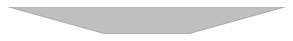

In [9]:
fig, axs = plt.subplots(figsize=(5,0.5))

xpoints = [0.35,0.65,1,0] #[0.3,0.6,.5,.4]
ypoints = [0,0,0.2,0.2]
axs.add_patch(patches.Polygon(xy=list(zip(xpoints,ypoints)), fill=True, color='grey', alpha=0.5))

plt.ylim(0,0.2)
axs.axis('off')

extent = axs.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('results/configurations/connection.svg', bbox_inches=extent, pad_inches=0)

0.03 0.024714857072281774 5.0 4.215765995543262


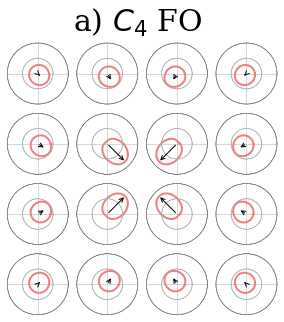

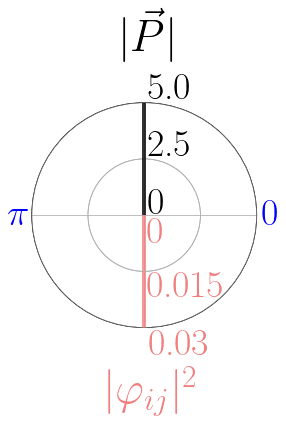

In [10]:
psi_analyse = psi_fo
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = 1 #(np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'a) $C_4$ FO', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fo.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fo_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fo.svg')
fig2 = sg.fromfile('results/configurations/fo_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(82, 380, 0.48) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

#fig.append([txt1,txt2,txt3,txt4])

fig.save('results/configurations/fo.svg')

0.06999999999999999 0.0672628781839835 9.0 7.638457171260624


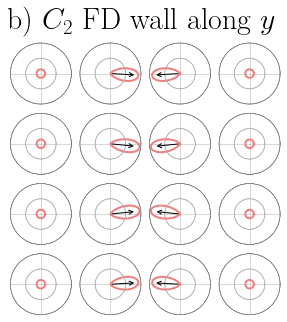

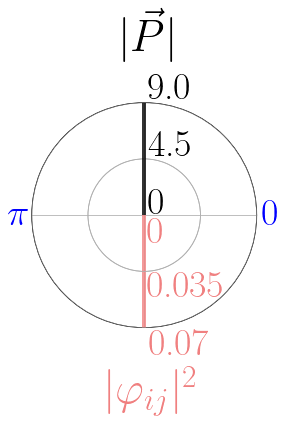

In [11]:
psi_analyse = psi_fdv
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = (np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'b) $C_2$ FD wall along $y$', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fdv.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fdv_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fdv.svg')
fig2 = sg.fromfile('results/configurations/fdv_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(82, 380, 0.48) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/fdv.svg')

0.06999999999999999 0.06726287868599583 9.0 7.638457171260734


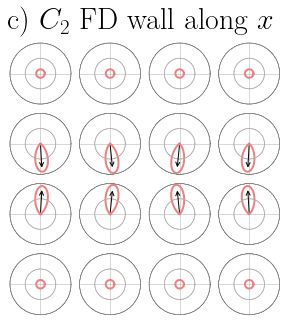

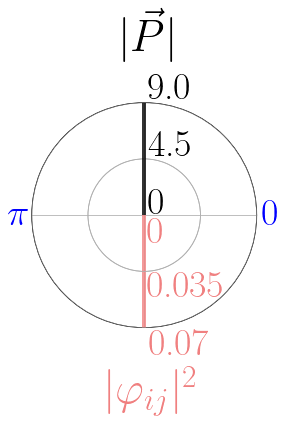

In [12]:
psi_analyse = psi_fdh
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = 1 #(np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'c) $C_2$ FD wall along $x$', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/fdh.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/fdh_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/fdh.svg')
fig2 = sg.fromfile('results/configurations/fdh_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(82, 380, 0.48) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/fdh.svg')

0.11000000000000001 0.10158543976977151 7.0 6.634786638056449


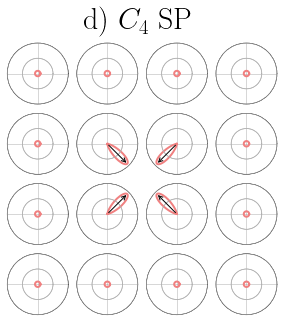

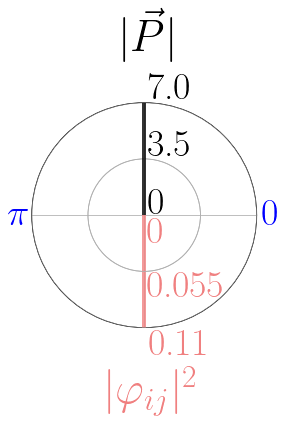

In [13]:
psi_analyse = psi_sp
chosen_My = 4
chosen_Mx = 4

wfn_manip = h_wavef.wavefunc_operations(params=params)

psi_small = wfn_manip.cut_out_rotor_region(psi_analyse,chosen_My,chosen_Mx)
Px, Py = get_polarization(x, psi_small, chosen_My, chosen_Mx)

scale_fac = (np.max(np.abs(psi_small)**2)/np.max(np.sqrt(Px**2+Py**2))).real
#max_psi = 1.03*np.max(psi_analyse)

''' 
Wavefunction Plot
'''
r_max_psi, r_max_P = plot_rotor_wavefunction_and_polarization(r'd) $C_4$ SP', x, 4, 4, np.sqrt(2*np.pi)*np.abs(psi_small)**2, Px.real, Py.real, max_psi)
plt.savefig('results/configurations/sp.svg', transparent=True)

''' 
Scale Plot
'''
plot_scale(r_max_psi, r_max_P)
plt.savefig('results/configurations/sp_scale.svg', transparent=True)

''' 
Combine Plots
'''
fig = sg.SVGFigure("20cm", "6.5cm")

fig1 = sg.fromfile('results/configurations/sp.svg')
fig2 = sg.fromfile('results/configurations/sp_scale.svg')
fig3 = sg.fromfile('results/configurations/connection.svg')

plot1 = fig1.getroot()
plot2 = fig2.getroot()
plot3 = fig3.getroot()

plot2.moveto(82, 380, 0.48) # 233
plot3.moveto(45, 320, 1)

fig.append([plot1,plot2,plot3])

fig.save('results/configurations/sp.svg')

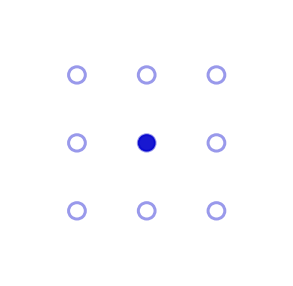

In [14]:
fig = plt.figure(figsize=(5,5))

for i in range(1,4):
    for j in range(1,4):
        circle = plt.Circle((i*0.25,j*0.25), 0.03, color='mediumblue', alpha=0.4, linewidth=3, fill=False)
        plt.gca().add_patch(circle)

circle = plt.Circle((0.5,0.5), 0.03, alpha=0.9, color='mediumblue')
plt.gca().add_patch(circle)

plt.axis('off')
plt.savefig('results/configurations/circle.svg', transparent=True)

In [15]:
import svgutils.transform as sg 

fig = sg.SVGFigure("75cm", "20cm")

fig1 = sg.fromfile('results/configurations/fo.svg')
fig2 = sg.fromfile('results/configurations/fdv.svg')
fig3 = sg.fromfile('results/configurations/fdh.svg')
fig4 = sg.fromfile('results/configurations/sp.svg')

figc1 = sg.fromfile('results/configurations/circle.svg')
figc2 = sg.fromfile('results/configurations/circle.svg')
figc3 = sg.fromfile('results/configurations/circle.svg')
figc4 = sg.fromfile('results/configurations/circle.svg')


plot1 = fig1.getroot()
plot1_1 = figc1.getroot()
plot2 = fig2.getroot()
plot2_1 = figc2.getroot()
plot3 = fig3.getroot()
plot3_1 = figc3.getroot()
plot4 = fig4.getroot()
plot4_1 = figc4.getroot()

plot2.moveto(350, 0)
plot2_1.moveto(350, 0)
plot3.moveto(700, 0)
plot3_1.moveto(700,0)
plot4.moveto(1050, 0)
plot4_1.moveto(1050, 0)

txt1 = sg.TextElement(5,40, "A)", size=30, weight="bold")
txt2 = sg.TextElement(355,40, "B)", size=30, weight="bold")
txt3 = sg.TextElement(705,40, "C)", size=30, weight="bold")
txt4 = sg.TextElement(1055,40, "D)", size=30, weight="bold")

fig.append([plot1,plot1_1,plot2,plot2_1,plot3,plot3_1,plot4,plot4_1])
#fig.append([txt1,txt2,txt3,txt4])

fig.save('results/configurations/configurations.svg')

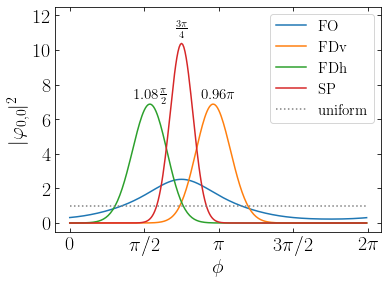

In [16]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

measure = n

plt.plot(x, np.abs(psi_fo[0,0])**2*measure, label=r'FO')
plt.plot(x, np.abs(psi_fdv[0,0])**2*measure, label=r'FDv')
plt.plot(x, np.abs(psi_fdh[0,0])**2*measure, label=r'FDh')
plt.plot(x, np.abs(psi_sp[0,0])**2*measure, label=r'SP')

plt.plot(x, np.abs(psi_sp[0,1])**2*measure, color='grey', linestyle='dotted', label=r'uniform')

fdv_max = x[np.argmax(np.abs(psi_fdv[0,0])**2)]
fdh_max = x[np.argmax(np.abs(psi_fdh[0,0])**2)]
sp_max = x[np.argmax(np.abs(psi_sp[0,0])**2)]

#plt.vlines(fdv_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:orange', linestyle='dashed', linewidth=1.2)
#plt.vlines(fdh_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:green', linestyle='dashed', linewidth=1.2)
#plt.vlines(sp_max, ymin=0, ymax=np.max(np.abs(psi_sp[0,0])**2)*measure, color='tab:red', linestyle='dashed', linewidth=1.2)

plt.annotate(str(round(fdv_max/np.pi,2))+r'$\pi$', xy=(0.92*fdv_max,7.2), fontsize=15)
plt.annotate(str(round(fdh_max/(np.pi/2),2))+r'$\frac{\pi}{2}$', xy=(0.8*fdh_max,7.2), fontsize=15)
plt.annotate(r'$\frac{3\pi}{4}$', xy=(0.95*sp_max,11), fontsize=15)

plt.xlabel(r'$\phi$', fontsize=font_size)
plt.ylabel(r'$|\varphi_{0,0}|^2$', fontsize=font_size)

plt.xticks([0,np.pi/2,np.pi,3*np.pi/2,2*np.pi], [r'0',r'$\pi/2$',r'$\pi$',r'$3\pi/2$',r'$2\pi$'], fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.ylim(-0.5,12.5)
#axs.set_yscale('log')

plt.legend(fontsize=15)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/configurations/wavefunction_comparison.svg')

# Polaron Size Characteristics

In [17]:
def get_psi_properties(file_path, check_size, check_sym):
    h5_io_object = h_in.io_hdf5()
    file_list = [f for f in os.listdir(file_path) if check_size in f and check_sym in f]

    V_0_arr = np.zeros(len(file_list), dtype=complex)

    E_arr = np.zeros(len(file_list), dtype=complex)
    B_arr = np.zeros(len(file_list), dtype=complex)
    V_arr = np.zeros(len(file_list), dtype=complex)
    Tx_arr = np.zeros(len(file_list), dtype=complex)
    Ty_arr = np.zeros(len(file_list), dtype=complex)

    i = 0
    for file in file_list:
        psi, params = h5_io_object.get_psi(file_path+file)

        energy_object = energy.energy(params=params)

        E = energy_object.calc_energy(psi) # in form [E, E_T, E_B, E_V]
        Tx, Ty = energy_object.deriv_dE_dt(psi)

        E_arr[i] = E[0]
        B_arr[i] = E[2]
        V_arr[i] = E[3]
        Ty_arr[i] = Ty
        Tx_arr[i] = Tx

        V_0_arr[i] = params['V_0']

        i += 1

    index_sort = np.argsort(V_0_arr)

    V_0_arr = V_0_arr[index_sort]

    E_arr = E_arr[index_sort]
    B_arr = B_arr[index_sort]
    V_arr = V_arr[index_sort]
    Tx_arr = Tx_arr[index_sort]
    Ty_arr = Ty_arr[index_sort]

    return V_0_arr, E_arr, B_arr, V_arr, Tx_arr, Ty_arr, psi, params

''' 
FO Results
'''
check_size = '_B_1.0_Mx_32_My_32_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_100_'
file_path = 'results/phase_diagram/fo/'

print('Reading results from FO calculations - please wait!')
V_0_arr_fo, E_arr_fo, B_arr_fo, V_arr_fo, Tx_arr_fo, Ty_arr_fo, psi_fo, params_fo = get_psi_properties(file_path, check_size, check_sym)


''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_256_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_110_'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_arr_fdv, E_arr_fdv, B_arr_fdv, V_arr_fdv, Tx_arr_fdv, Ty_arr_fdv, psi_fdv, params_fdv = get_psi_properties(file_path, check_size, check_sym)


''' 
SP Results
'''
check_size = '_B_1.0_Mx_8_My_8_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_290_'
file_path = 'results/phase_diagram/sp/'

print('Reading results from SP calculations - please wait!')
V_0_arr_sp, E_arr_sp, B_arr_sp, V_arr_sp, Tx_arr_sp, Ty_arr_sp, psi_sp, params_sp = get_psi_properties(file_path, check_size, check_sym)

Reading results from FO calculations - please wait!
Reading results from FDv calculations - please wait!
Reading results from SP calculations - please wait!


In [18]:
def outfold_array(psi, My, Mx):
    psi_n = psi.copy()
    for i in range(My):
        for j in range(Mx):
            psi_ij = psi[(i+int(My/2))%My,(j+int(Mx/2))%Mx] 
            psi_n[i,j] = psi_ij
    return psi_n

In [62]:
import class_mass_size as mass_size

dx = x[1]-x[0]
#size_object_fo = mass_size.polaron_size(params=params_fo)
#pol_size_fo = size_object_fo.calc_polaron_size(psi_fo, '1')
px_vec_fo, py_vec_fo = get_polarization(x, psi_fo, 32, 32)
p_abs_fo = np.abs(px_vec_fo**2+py_vec_fo**2)**0.5
p_abs_fo = outfold_array(p_abs_fo, 32, 32)

#size_object_fdv = mass_size.polaron_size(params=params_fdv)
#pol_size_fdv = size_object_fdv.calc_polaron_size(psi_fdv, '1')
px_vec_fdv, py_vec_fdv = get_polarization(x, psi_fdv, 256, 4)
p_abs_fdv = np.abs(px_vec_fdv**2+py_vec_fdv**2)**0.5
p_abs_fdv = outfold_array(p_abs_fdv, 256, 4)

#size_object_sp = mass_size.polaron_size(params=params_sp)
#pol_size_sp = size_object_sp.calc_polaron_size(psi_sp, '1')
px_vec_sp, py_vec_sp = get_polarization(x, psi_sp, 8, 8)
p_abs_sp = np.abs(px_vec_sp**2+py_vec_sp**2)**0.5
p_abs_sp = outfold_array(p_abs_sp, 8, 8)

0.02454369260617026
0.9999138746454397
-0.7262324711473975
1.1102230246251565e-16
0.7262324711473975


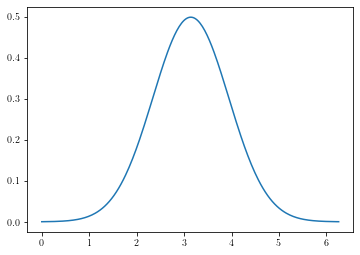

In [51]:
sigma = 0.8
y_gauss = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-np.pi)**2/(2*sigma**2))
dx = x[1]-x[0]
norm_gauss = np.sum(y_gauss*dx)

pol_x = np.sum(y_gauss*np.cos(x)*dx)
pol_y = np.sum(y_gauss*np.sin(x)*dx)
pol_tot = (pol_x**2 + pol_y**2)**0.5

print(dx)
print(norm_gauss)
print(pol_x)
print(pol_y)
print(pol_tot)

plt.plot(x,y_gauss)

## Rotor variance and polarization vector FO

NameError: name 'pol_size_fo' is not defined

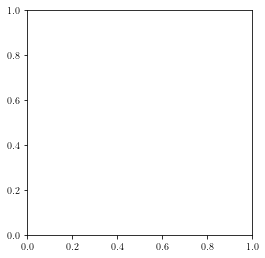

In [20]:
X, Y = np.meshgrid(np.arange(-5,6,1), np.arange(-5,6,1)) # np.meshgrid(np.arange(-4,5,1), np.arange(-4,5,1))

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

pc = plt.pcolor(X, Y, pol_size_fo[11:21,11:21], cmap='gist_gray', vmin=0.6, vmax=1.0) # norm=matplotlib.colors.LinNorm(vmin=0.1, vmax=1))

cax = ax.inset_axes([3.2, -4.3, 0.4, 5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical') #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=12)
cbar.set_ticks(ticks=[0.6, 0.7, 0.8, 0.9, 1], labels=['0.6','','0.8','','1.0'])
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(c) $V_0/t=0.5$, $C_4$ FO', xy=(0.2, -0.1), xytext=(-4.5, 4), fontsize=20, color='black')

ax.annotate("", xy=(0.2, 0.2), xytext=(0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red')) #facecolor='red', 
ax.annotate("", xy=(-0.2, -0.2), xytext=(-0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.2, 0.2), xytext=(-0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.2, -0.2), xytext=(0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(-1.2, -0.5), xytext=(-1.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-1.2, 0.5), xytext=(-1.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(1.2, -0.5), xytext=(1.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(1.2, 0.5), xytext=(1.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(-0.5, 1.2), xytext=(-0.9, 1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.5, 1.2), xytext=(0.9, 1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.5, -1.2), xytext=(-0.9, -1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.5, -1.2), xytext=(0.9, -1.9), arrowprops=dict(arrowstyle="->", color='red'))


plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)
plt.yticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/configurations/pol_size/pol_size_fo.svg')

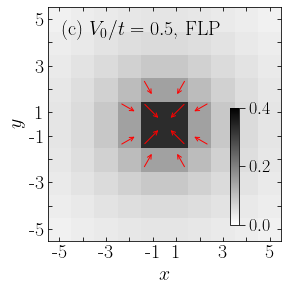

In [97]:
X, Y = np.meshgrid(np.arange(-5,6,1), np.arange(-5,6,1)) # np.meshgrid(np.arange(-4,5,1), np.arange(-4,5,1))

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[4,4]) #[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

pc = plt.pcolormesh(X, Y, p_abs_fo[11:21,11:21], cmap='binary', vmin=0.0, vmax=0.4) # norm=matplotlib.colors.LinNorm(vmin=0.1, vmax=1))

cax = ax.inset_axes([2.8, -4.3, 0.4, 5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical') #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=18)
#cbar.set_ticks(ticks=[0, 1, 2], labels=['0','1','2'])
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(c) $V_0/t=0.5$, FLP', xy=(0.2, -0.1), xytext=(-4.4, 3.8), fontsize=20, color='black')

ax.annotate("", xy=(0.2, 0.2), xytext=(0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red')) #facecolor='red', 
ax.annotate("", xy=(-0.2, -0.2), xytext=(-0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.2, 0.2), xytext=(-0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.2, -0.2), xytext=(0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(-1.2, -0.5), xytext=(-1.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-1.2, 0.5), xytext=(-1.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(1.2, -0.5), xytext=(1.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(1.2, 0.5), xytext=(1.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(-0.5, 1.2), xytext=(-0.9, 1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.5, 1.2), xytext=(0.9, 1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.5, -1.2), xytext=(-0.9, -1.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.5, -1.2), xytext=(0.9, -1.9), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)
plt.yticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)

plt.xlim(-5,5)
plt.ylim(-5,5)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)
fig.set_size_inches(4.3, 4.3, forward=True)

plt.savefig('results/configurations/pol_size/p_vec_fo.svg')

## Rotor variance and polarization vector FDv

In [ ]:
#X, Y = np.meshgrid(np.arange(-2,3,1), np.arange(-4,5,1))

X, Y = np.meshgrid(10*np.arange(-2,3,1), np.arange(-20,21,1))


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)], layout="constrained") #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

#pc = plt.pcolormesh(X, Y, pol_size_fdv[124:132,0:4], cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)) #, vmin=0, vmax=1)

pc = ax.pcolormesh(X, Y, pol_size_fdv[108:148,0:4], cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1)) 

cax = ax.inset_axes([11, -17, 1.3, 15], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical')
#cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=13)
cbar.ax.minorticks_off()
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(b) $V_0/t=0.6$, $C_2$ FDW$_y$', xy=(0.2, -0.1), xytext=(-17, 15), fontsize=20, color='black')

ax.annotate("", xy=(-2, 0), xytext=(-9, 0), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-2, 4.8), xytext=(-9, 5), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(2, 4.8), xytext=(9, 5), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(2, 0), xytext=(9, 0), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-2, -4.8), xytext=(-9, -5), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(2, -4.8), xytext=(9, -5), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlim(-20,20)
plt.ylim(-20,20) 

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-20,-15,-5,5,15,20],[r'',r'-2',r'-1',r'1',r'2',r''], fontsize=font_size)
plt.yticks([-20,-15,-10,-5,0,5,10,15,20],[r'-20',r'',r'-10',r'',r'0',r'',r'10',r'',r'20'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)

plt.savefig('results/configurations/pol_size/pol_size_fdv.svg')

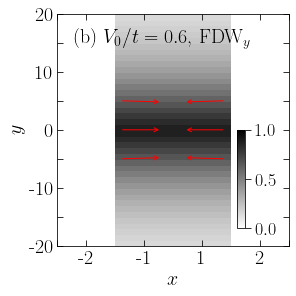

In [83]:
#X, Y = np.meshgrid(np.arange(-2,3,1), np.arange(-4,5,1))

X, Y = np.meshgrid(10*np.arange(-2,3,1), np.arange(-20,21,1))


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)], layout="constrained") #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

#pc = plt.pcolormesh(X, Y, pol_size_fdv[124:132,0:4], cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)) #, vmin=0, vmax=1)

pc = ax.pcolormesh(X, Y, p_abs_fdv[108:148,0:4], cmap='binary', vmin=0, vmax=1.0) #, norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1)) 

cax = ax.inset_axes([11, -17, 1.5, 17], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical')
#cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=18)
cbar.ax.minorticks_off()
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(b) $V_0/t=0.6$, FDW$_y$', xy=(0.2, -0.1), xytext=(-17, 15), fontsize=20, color='black')

ax.annotate("", xy=(-2, 0), xytext=(-9, 0), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-2, 4.8), xytext=(-9, 5), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(2, 4.8), xytext=(9, 5), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(2, 0), xytext=(9, 0), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-2, -4.8), xytext=(-9, -5), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(2, -4.8), xytext=(9, -5), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlim(-20,20)
plt.ylim(-20,20) 

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-20,-15,-5,5,15,20],[r'',r'-2',r'-1',r'1',r'2',r''], fontsize=font_size)
plt.yticks([-20,-15,-10,-5,0,5,10,15,20],[r'-20',r'',r'-10',r'',r'0',r'',r'10',r'',r'20'], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)
fig.set_size_inches(4, 4, forward=True)

plt.savefig('results/configurations/pol_size/p_vec_fdv.svg')

## Rotor variance and polarization vector FDh

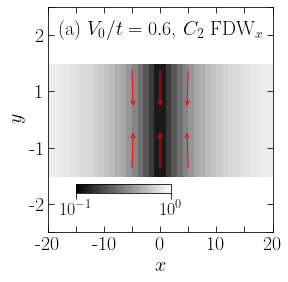

In [254]:
X, Y = np.meshgrid(np.arange(-20,21,1), 10*np.arange(-2,3,1))

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

pc = plt.pcolormesh(X, Y, pol_size_fdv[108:148,0:4].T, cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1)) #, vmin=0, vmax=1)

cax = ax.inset_axes([-15, -13, 17, 1.5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='horizontal')
#cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=18)
cbar.ax.minorticks_off()
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(a) $V_0/t=0.6$, $C_2$ FDW$_x$', xy=(0.2, -0.1), xytext=(-18, 15), fontsize=20, color='black')

ax.annotate("", xy=(0, -2), xytext=(0, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(4.8, -2), xytext=(5, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(4.8, 2), xytext=(5, 9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(0, 2), xytext=(0, 9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-4.8, -2), xytext=(-5, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-4.8, 2), xytext=(-5, 9), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlim(-20,20)
plt.ylim(-20,20) 

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-20,-15,-10,-5,0,5,10,15,20],[r'-20',r'',r'-10',r'',r'0',r'',r'10',r'',r'20'], fontsize=font_size)
plt.yticks([-20,-15,-5,5,15,20],[r'',r'-2',r'-1',r'1',r'2',r''], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)

plt.savefig('results/configurations/pol_size/pol_size_fdh.svg')

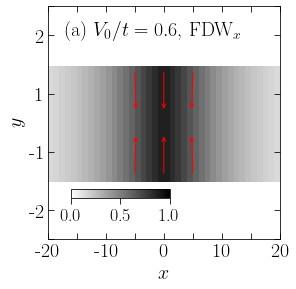

In [87]:
#X, Y = np.meshgrid(np.arange(-2,3,1), np.arange(-4,5,1))

#X, Y = np.meshgrid(10*np.arange(-2,3,1), np.arange(-20,21,1))
X, Y = np.meshgrid(np.arange(-20,21,1), 10*np.arange(-2,3,1))


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)], layout="constrained") #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

#pc = plt.pcolormesh(X, Y, pol_size_fdv[124:132,0:4], cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)) #, vmin=0, vmax=1)

pc = ax.pcolormesh(X, Y, p_abs_fdv[108:148,0:4].T, cmap='binary', vmin=0.0, vmax=1.0) #, norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=1)) 

cax = ax.inset_axes([-16, -13, 17, 1.5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='horizontal')
#cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=18)
cbar.ax.minorticks_off()
cbar.set_ticks(ticks=[0.0, 0.5, 1.0], labels=['0.0','0.5','1.0'])
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(a) $V_0/t=0.6$, FDW$_x$', xy=(0.2, -0.1), xytext=(-17, 15), fontsize=20, color='black')

ax.annotate("", xy=(0, -2), xytext=(0, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(4.8, -2), xytext=(5, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(4.8, 2), xytext=(5, 9), arrowprops=dict(arrowstyle="->", color='red'))

ax.annotate("", xy=(0, 2), xytext=(0, 9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-4.8, -2), xytext=(-5, -9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-4.8, 2), xytext=(-5, 9), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlim(-20,20)
plt.ylim(-20,20) 

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-20,-15,-10,-5,0,5,10,15,20],[r'-20',r'',r'-10',r'',r'0',r'',r'10',r'',r'20'], fontsize=font_size)
plt.yticks([-20,-15,-5,5,15,20],[r'',r'-2',r'-1',r'1',r'2',r''], fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)

fig.set_size_inches(4, 4, forward=True)

plt.savefig('results/configurations/pol_size/p_vec_fdh.svg')

## Rotor variance and polarization vector SP

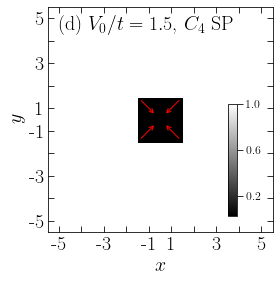

In [134]:
X, Y = np.meshgrid(np.arange(-4,5,1), np.arange(-4,5,1))

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

pc = plt.pcolormesh(X, Y, pol_size_sp, cmap='gist_gray') #norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)) #, vmin=0, vmax=1)

cax = ax.inset_axes([3, -4.3, 0.4, 5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical') #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=12)
cbar.set_ticks(ticks=[0.2, 0.6, 1], labels=['0.2', '0.6', '1.0'])
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

#cbar = fig.colorbar(pc) #, orientation="horizontal", pad=0.2)
#cbar.ax.tick_params(length=6, labelsize=font_size)
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
#cbar.solids.set_rasterized(True)
#pc.set_edgecolor('face')

ax.annotate(r'(d) $V_0/t=1.5$, $C_4$ SP', xy=(0.2, -0.1), xytext=(-4.5, 4), fontsize=20, color='black')

ax.annotate("", xy=(0.2, 0.2), xytext=(0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red')) #facecolor='red', 
ax.annotate("", xy=(-0.2, -0.2), xytext=(-0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.2, 0.2), xytext=(-0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.2, -0.2), xytext=(0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)
plt.yticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)

plt.xlim(-5,5)
plt.ylim(-5,5) 

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/configurations/pol_size/pol_size_sp.svg')

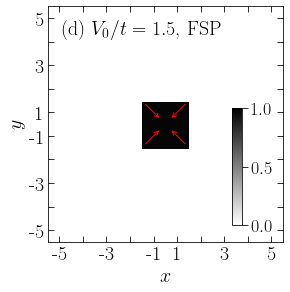

In [88]:
X, Y = np.meshgrid(np.arange(-4,5,1), np.arange(-4,5,1))


A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)], layout="constrained") #, subplot_kw={"projection": "3d"})
ax.set_aspect("equal")

#plt.title(r'FO, $B=0.5\cdot 10^{-2}t$', fontsize=font_size)

#pc = plt.pcolormesh(X, Y, pol_size_fdv[124:132,0:4], cmap='gist_gray', norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=1)) #, vmin=0, vmax=1)

pc = ax.pcolormesh(X, Y, p_abs_sp, cmap='binary', vmin=0, vmax=1.0)#, norm=matplotlib.colors.LogNorm(vmin=1, vmax=10)) 

cax = ax.inset_axes([2.85, -4.3, 0.4, 5], transform=ax.transData)
cbar = fig.colorbar(pc, shrink=0.6, cax=cax, orientation='vertical') #, orientation="horizontal", pad=0.2)
cbar.ax.tick_params(length=6, labelsize=18)
#cbar.set_ticks(ticks=[0.2, 0.6, 1], labels=['0.2', '0.6', '1.0'])
#cbar.set_label(label=r'$\sigma^2_{\phi}/\sigma^2_0$', size=font_size)
cbar.solids.set_rasterized(True)
pc.set_edgecolor('face')

ax.annotate(r'(d) $V_0/t=1.5$, FSP', xy=(0.2, -0.1), xytext=(-4.4, 3.8), fontsize=20, color='black')

ax.annotate("", xy=(0.2, 0.2), xytext=(0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red')) #facecolor='red', 
ax.annotate("", xy=(-0.2, -0.2), xytext=(-0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(-0.2, 0.2), xytext=(-0.9, 0.9), arrowprops=dict(arrowstyle="->", color='red'))
ax.annotate("", xy=(0.2, -0.2), xytext=(0.9, -0.9), arrowprops=dict(arrowstyle="->", color='red'))

plt.xlabel(r'$x$', fontsize=font_size)
plt.ylabel(r'$y$', fontsize=font_size)

plt.xticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)
plt.yticks([-4.5,-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5,3.5,4.5],[r'-5',r'',r'-3',r'',r'-1',r'1',r'',r'3',r'',r'5'], fontsize=font_size)

plt.xlim(-5,5)
plt.ylim(-5,5) 

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(which='minor', axis='x', direction='in', top=True)
plt.tick_params(which='minor', axis='y', direction='in', right=True)

ax.set_aspect(1)

fig.set_size_inches(3.95, 3.95, forward=True)

plt.savefig('results/configurations/pol_size/p_vec_sp.svg')

# Polaron size determination

First, we determine the polaron size in the FO for various $B$ values.

In [35]:
''' 
FO Results
'''
check_size = '_B_2.0_Mx_80_My_80_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_40_'
file_path = 'results/eff_mass/fo/'

print('Reading results from FO calculations - please wait!')
V_0_s_fo, E_s_fo, B_s_fo, V_s_fo, Tx_s_fo, Ty_s_fo, psi_s_fo_B_2, params_s_fo_B_2 = get_psi_properties(file_path, check_size, check_sym)


check_size = '_B_200.0_Mx_80_My_80_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_40_'
file_path = 'results/eff_mass/fo/'

print('Reading results from FO calculations - please wait!')
V_0_s_fo, E_s_fo, B_s_fo, V_s_fo, Tx_s_fo, Ty_s_fo, psi_s_fo_B_200, params_s_fo_B_200 = get_psi_properties(file_path, check_size, check_sym)

Reading results from FO calculations - please wait!
Reading results from FO calculations - please wait!


In [36]:
size_object_fo = mass_size.polaron_size(params=params_s_fo_B_2)
pol_size_fo_B_2 = size_object_fo.calc_polaron_size(psi_s_fo_B_2, '2')

Mx_arr = np.arange(int(len(pol_size_fo_B_2)/2))+1
pol_size_fo_x_B_2 = pol_size_fo_B_2[int(len(pol_size_fo_B_2)/2)][int(len(pol_size_fo_B_2)/2):]

/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:239: ComplexWarning: Casting complex values to real discards the imaginary part
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
/mnt/nfs/clustersw/Debian/bullseye/JupyterPython/2.0/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [37]:
size_object_fo = mass_size.polaron_size(params=params_s_fo_B_200)
pol_size_fo_B_200 = size_object_fo.calc_polaron_size(psi_s_fo_B_200, '2')

Mx_arr = np.arange(int(len(pol_size_fo_B_200)/2))+1
pol_size_fo_x_B_200 = pol_size_fo_B_200[int(len(pol_size_fo_B_200)/2)][int(len(pol_size_fo_B_200)/2):]

In [38]:
def func(x, a):
    return 1+(pol_size_fo_x_B_2[0]-1)*np.exp(-(x-1)/a) #a*np.exp(b*x)+c # 
    
popt, pcov = scipy.optimize.curve_fit(func, Mx_arr, pol_size_fo_x_B_2, p0 = [10]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit = np.linspace(Mx_arr[0], Mx_arr[-1], 100)
y_fit = func(x_fit, *popt)
print('B = 2, M_p =', *popt)

def func(x, a):
    return 1+(pol_size_fo_x_B_200[0]-1)*np.exp(-(x-1)/a) #a*np.exp(b*x)+c # 

popt, pcov = scipy.optimize.curve_fit(func, Mx_arr, pol_size_fo_x_B_200, p0 = [10]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit = np.linspace(Mx_arr[0], Mx_arr[-1], 100)
y_fit = func(x_fit, *popt)
print('B = 200, M_p =', *popt)

B = 2, M_p = 2.0539493524888663
B = 200, M_p = 0.6703595754224497


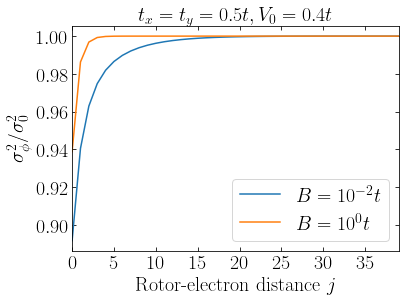

In [47]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$\Delta_t = 0, V_0 = 0.4t$', fontsize=font_size)

plt.plot(Mx_arr-1, 2-pol_size_fo_x_B_2, label=r'$B = 10^{-2}t$')
plt.plot(Mx_arr-1, 2-pol_size_fo_x_B_200, label=r'$B = 10^{0}t$')

plt.xlim(0,39)

plt.xlabel(r'Rotor-electron distance $j$', fontsize=font_size)
plt.ylabel(r'$\sigma_{\phi}^2/\sigma_0^2$', fontsize=font_size)

ax.annotate(r'$t_x=t,t_y=0$', xy=(0.05, -1.5), xytext=(0.05, -1.8), fontsize=15, color='black')
ax.annotate(r'$t_x=t_y=0.5t$', xy=(0.8, -1.2), xytext=(1, -1.2), fontsize=15, color='black')

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=4)
plt.savefig('results/configurations/pol_size/polaron_size_fo_B_comp.svg', bbox_inches='tight', dpi=50)

## Polaron size in Ferro-domains

In [40]:
''' 
FDv Results
'''
check_size = '_B_1.0_Mx_4_My_256_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_150_'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_s_fdv, E_s_fdv, B_s_fdv, V_s_fdv, Tx_s_fdv, Ty_s_fdv, psi_s_fdv_B_1, params_s_fdv_B_1 = get_psi_properties(file_path, check_size, check_sym)

check_size = '_B_10.0_Mx_4_My_256_qx_0_qy_0'
check_sym = 'tx_100.0_ty_100.0_V0_150_'
file_path = 'results/phase_diagram/fdv/'

print('Reading results from FDv calculations - please wait!')
V_0_s_fdv, E_s_fdv, B_s_fdv, V_s_fdv, Tx_s_fdv, Ty_s_fdv, psi_s_fdv_B_10, params_s_fdv_B_10 = get_psi_properties(file_path, check_size, check_sym)

Reading results from FDv calculations - please wait!
Reading results from FDv calculations - please wait!


In [41]:
size_object_fdv = mass_size.polaron_size(params=params_s_fdv_B_1)
pol_size_fdv_B_1 = size_object_fdv.calc_polaron_size(psi_s_fdv_B_1, '1')

My_arr = np.arange(int(len(pol_size_fdv_B_1)/2))+1
pol_size_fdv_y_B_1 = pol_size_fdv_B_1[int(len(pol_size_fdv_B_1)/2)][int(len(pol_size_fdv_B_1)/2):]

In [42]:
size_object_fdv = mass_size.polaron_size(params=params_s_fdv_B_10)
pol_size_fdv_B_10 = size_object_fdv.calc_polaron_size(psi_s_fdv_B_10, '1')

My_arr = np.arange(int(len(pol_size_fdv_B_10)/2))+1
pol_size_fdv_y_B_10 = pol_size_fdv_B_10[int(len(pol_size_fdv_B_10)/2)][int(len(pol_size_fdv_B_10)/2):]

In [43]:
My_arr = np.arange(int(len(pol_size_fdv_B_1)/2))+1
pol_size_fdv_y_B_1 = pol_size_fdv_B_1.T[int(len(pol_size_fdv_B_1.T)/2)][:int(len(pol_size_fdv_B_1)/2)]

pol_size_fdv_y_B_10 = pol_size_fdv_B_10.T[int(len(pol_size_fdv_B_10.T)/2)][int(len(pol_size_fdv_B_10)/2):]

In [44]:
def func(x, a):
    return 1+(pol_size_fdv_y_B_1[-1]-1)*np.exp(-(x-1)/a) #1+(pol_size_fdv_line[0]-1)*np.exp(-(x-1)/a) #a*np.exp(b*x)+c # 
    
popt, pcov = scipy.optimize.curve_fit(func, My_arr, pol_size_fdv_y_B_1[::-1], p0 = [10]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit_fdv = np.linspace(My_arr[0], My_arr[-1], 100)
y_fit_fdv = func(x_fit_fdv, *popt)

print('B = 1, M_p =', *popt)


def func(x, a):
    return 1+(pol_size_fdv_y_B_10[0]-1)*np.exp(-(x-1)/a) #1+(pol_size_fdv_line[0]-1)*np.exp(-(x-1)/a) #a*np.exp(b*x)+c # 
    
popt, pcov = scipy.optimize.curve_fit(func, My_arr, pol_size_fdv_y_B_10, p0 = [10]) #bounds=([30,0,-10], [50, 100, 0]))
x_fit_fdv = np.linspace(My_arr[0], My_arr[-1], 100)
y_fit_fdv = func(x_fit_fdv, *popt)

print('B = 10, M_p =', *popt)

B = 1, M_p = 11.03868766557381
B = 10, M_p = 2.7936876612087196


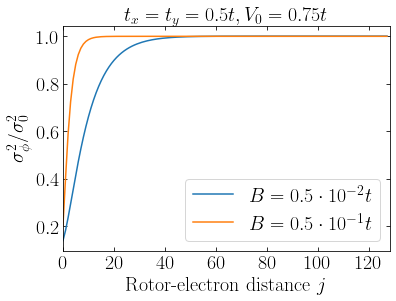

In [45]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, ax = plt.subplots(figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)]) #, subplot_kw={"projection": "3d"})
#ax.set_aspect("equal")

plt.title(r'$\Delta_t = 0, V_0 = 0.75t$', fontsize=font_size)

plt.plot(My_arr-1, pol_size_fdv_y_B_1[::-1]+0.02, label=r'$B = 0.5\cdot 10^{-2}t$')
plt.plot(My_arr-1, pol_size_fdv_y_B_10, label=r'$B = 0.5\cdot 10^{-1}t$')

plt.xlim(0,128)

plt.xlabel(r'Rotor-electron distance $j$', fontsize=font_size)
plt.ylabel(r'$\sigma_{\phi}^2/\sigma_0^2$', fontsize=font_size)

ax.annotate(r'$t_x=t,t_y=0$', xy=(0.05, -1.5), xytext=(0.05, -1.8), fontsize=15, color='black')
ax.annotate(r'$t_x=t_y=0.5t$', xy=(0.8, -1.2), xytext=(1, -1.2), fontsize=15, color='black')

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

plt.tick_params(axis='x', direction='in', length=4, top=True)
plt.tick_params(axis='y', direction='in', length=4, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.legend(fontsize=font_size, loc=4)
plt.savefig('results/configurations/pol_size/polaron_size_fdv_B_comp.svg', bbox_inches='tight', dpi=50)

TODO: determine the polaron size for a totally asymmetric lattice, i.e. $\Delta_t = -1$, so that we can compare the extension. There is currently one sentence in the main text that says this, so we should back it up somehow!